# Evaluate *ritme* trials 

Note as notebook `n2_run_ritme_model.ipynb` this notebook can be run in the `ritme_model` conda environment.

## Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from ritme.evaluate_mlflow import (
    barplot_metric,
    create_color_map,
    extract_run_config,
    parallel_coordinates_plot,
    plot_avg_history_per_model_type,
    plot_complexity_vs_metric,
    plot_metric_history_per_model_type,
    plot_trend_over_time,
    post_process_data_transform,
    violinplot_metric,
)

pio.templates.default = "seaborn"
plt.rcParams.update({"font.family": "DejaVu Sans"})
plt.style.use("tableau-colorblind10")

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

warnings.filterwarnings("ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
def boxplot_metric(trials, metric_col, metric_name, group_col, group_name):
    """Plot distribution of metric within each group using a boxplot,
    sorted by increasing median, hiding outliers."""
    # compute color map and sort groups by median of the metric
    _, color_map = create_color_map(trials, group_col)
    medians = trials.groupby(group_col)[metric_col].median().sort_values()
    order = medians.index.tolist()

    fig, ax = plt.subplots(figsize=(15, 6), dpi=400)
    sns.boxplot(
        x=metric_col,
        y=group_col,
        data=trials,
        orient="h",
        order=order,
        palette=color_map,
        width=0.6,
        showfliers=False,
        linewidth=1.5,
        ax=ax,
    )

    ax.set_xlabel(metric_name, labelpad=10)
    ax.set_ylabel(group_name, labelpad=10)
    ax.set_title(f"Distribution of {metric_name} by {group_name}", pad=15)

    plt.tight_layout()
    plt.show()

In [3]:
######## USER INPUTS ########

# path to MLflow logs
log_folder_location = "../euler_logs/u1_all_qmc/mlruns"

# whether to only analyze one model type or all (="all")
model_type = "rf"
# whether to display all trials (top_n=None) or just top N trials of the
# model_type selected before
top_n = None

# static or dynamic plots (static_plots=False) if available?
static_plots = True

# whether to display trial_id as x-axis in plots
display_trial_id = False
######## END USER INPUTS #####

## Extract trial information

In [4]:
# extract all trial information
mlflow.set_tracking_uri(log_folder_location)

all_trials = mlflow.search_runs(
    order_by=["metrics.rmse_val ASC"], search_all_experiments=True
)

print(f"Found {all_trials.shape[0]} trials")

Found 700 trials


In [5]:
# post-process data_transform entry - only needed in MLflow since WandB updates
# these automatically
all_trials = post_process_data_transform(all_trials)

In [6]:
if model_type != "all":
    print(f"Analyzing trials for model type: {model_type}")
    all_trials = all_trials[all_trials["params.model"] == model_type]

# select trails to analyze
if top_n is not None:
    print(f"Analyzing top {top_n} trials")
    all_trials = all_trials.head(top_n)

print(f"Selected {all_trials.shape[0]} trials")

Analyzing trials for model type: rf
Selected 100 trials


## Insights on performance per model type

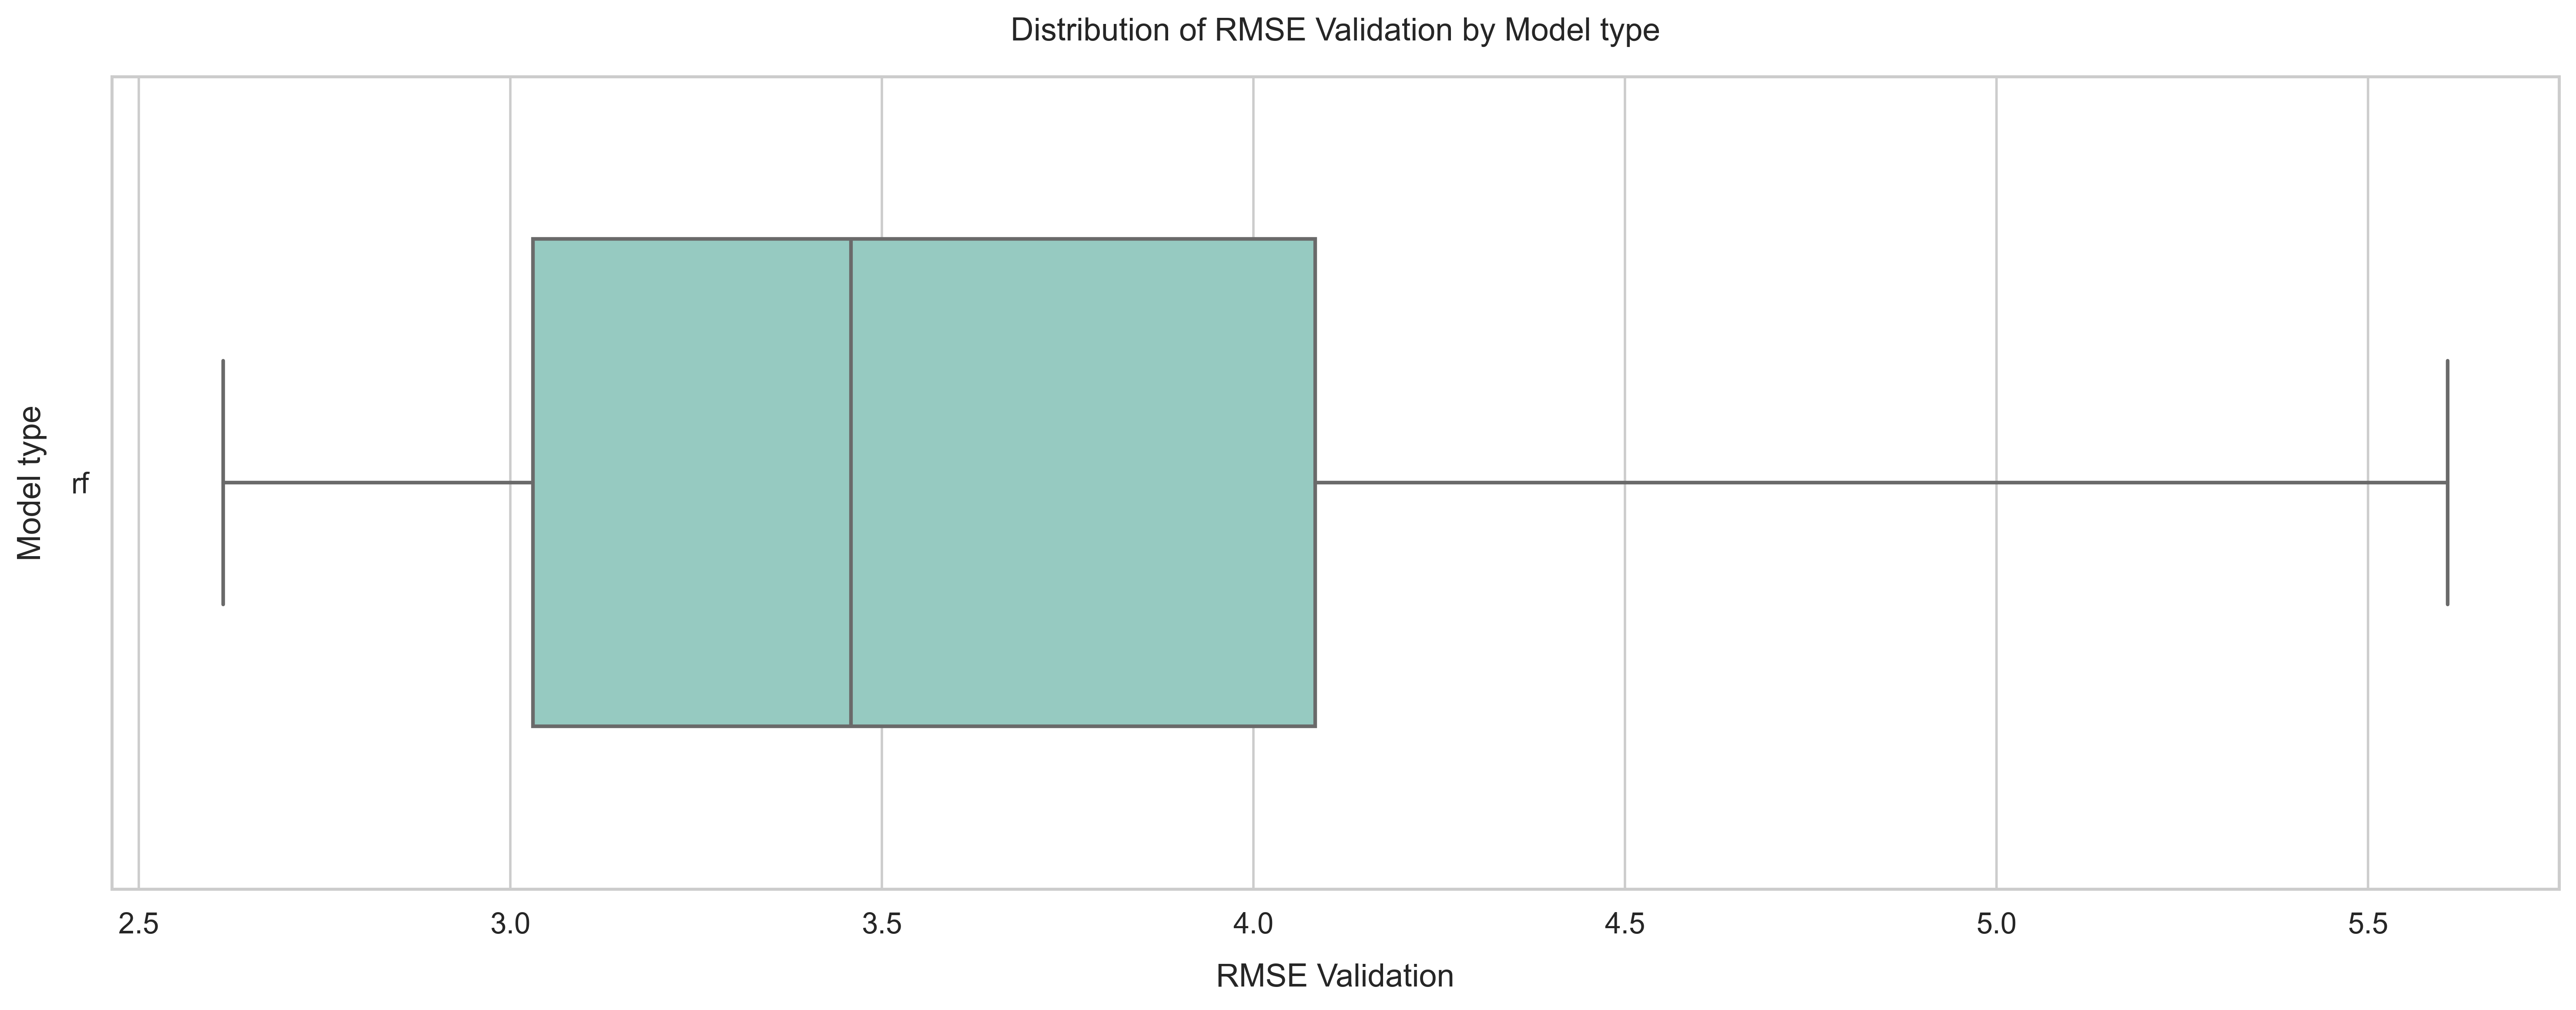

In [13]:
boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col="params.model",
    group_name="Model type",
)

In [ ]:
barplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col="params.model",
    group_name="Model type",
    display_trial_name=display_trial_id,
    top_n=top_n,
)

## Model complexity vs. performance

In [ ]:
plot_complexity_vs_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col="params.model",
    group_name="Model type",
    static=static_plots,  # Set to False for interactive plotly graph
)

In [ ]:
violinplot_metric(
    all_trials,
    metric_col="metrics.nb_features",
    metric_name="Number of features",
    group_col="params.model",
    group_name="Model type",
)

In [ ]:
first_metric_col = "metrics.nb_features"
first_metric_name = "# features"
parallel_coordinates_plot(all_trials, first_metric_col, first_metric_name)

## Performance vs. feature engineering

### Effect of data transformation

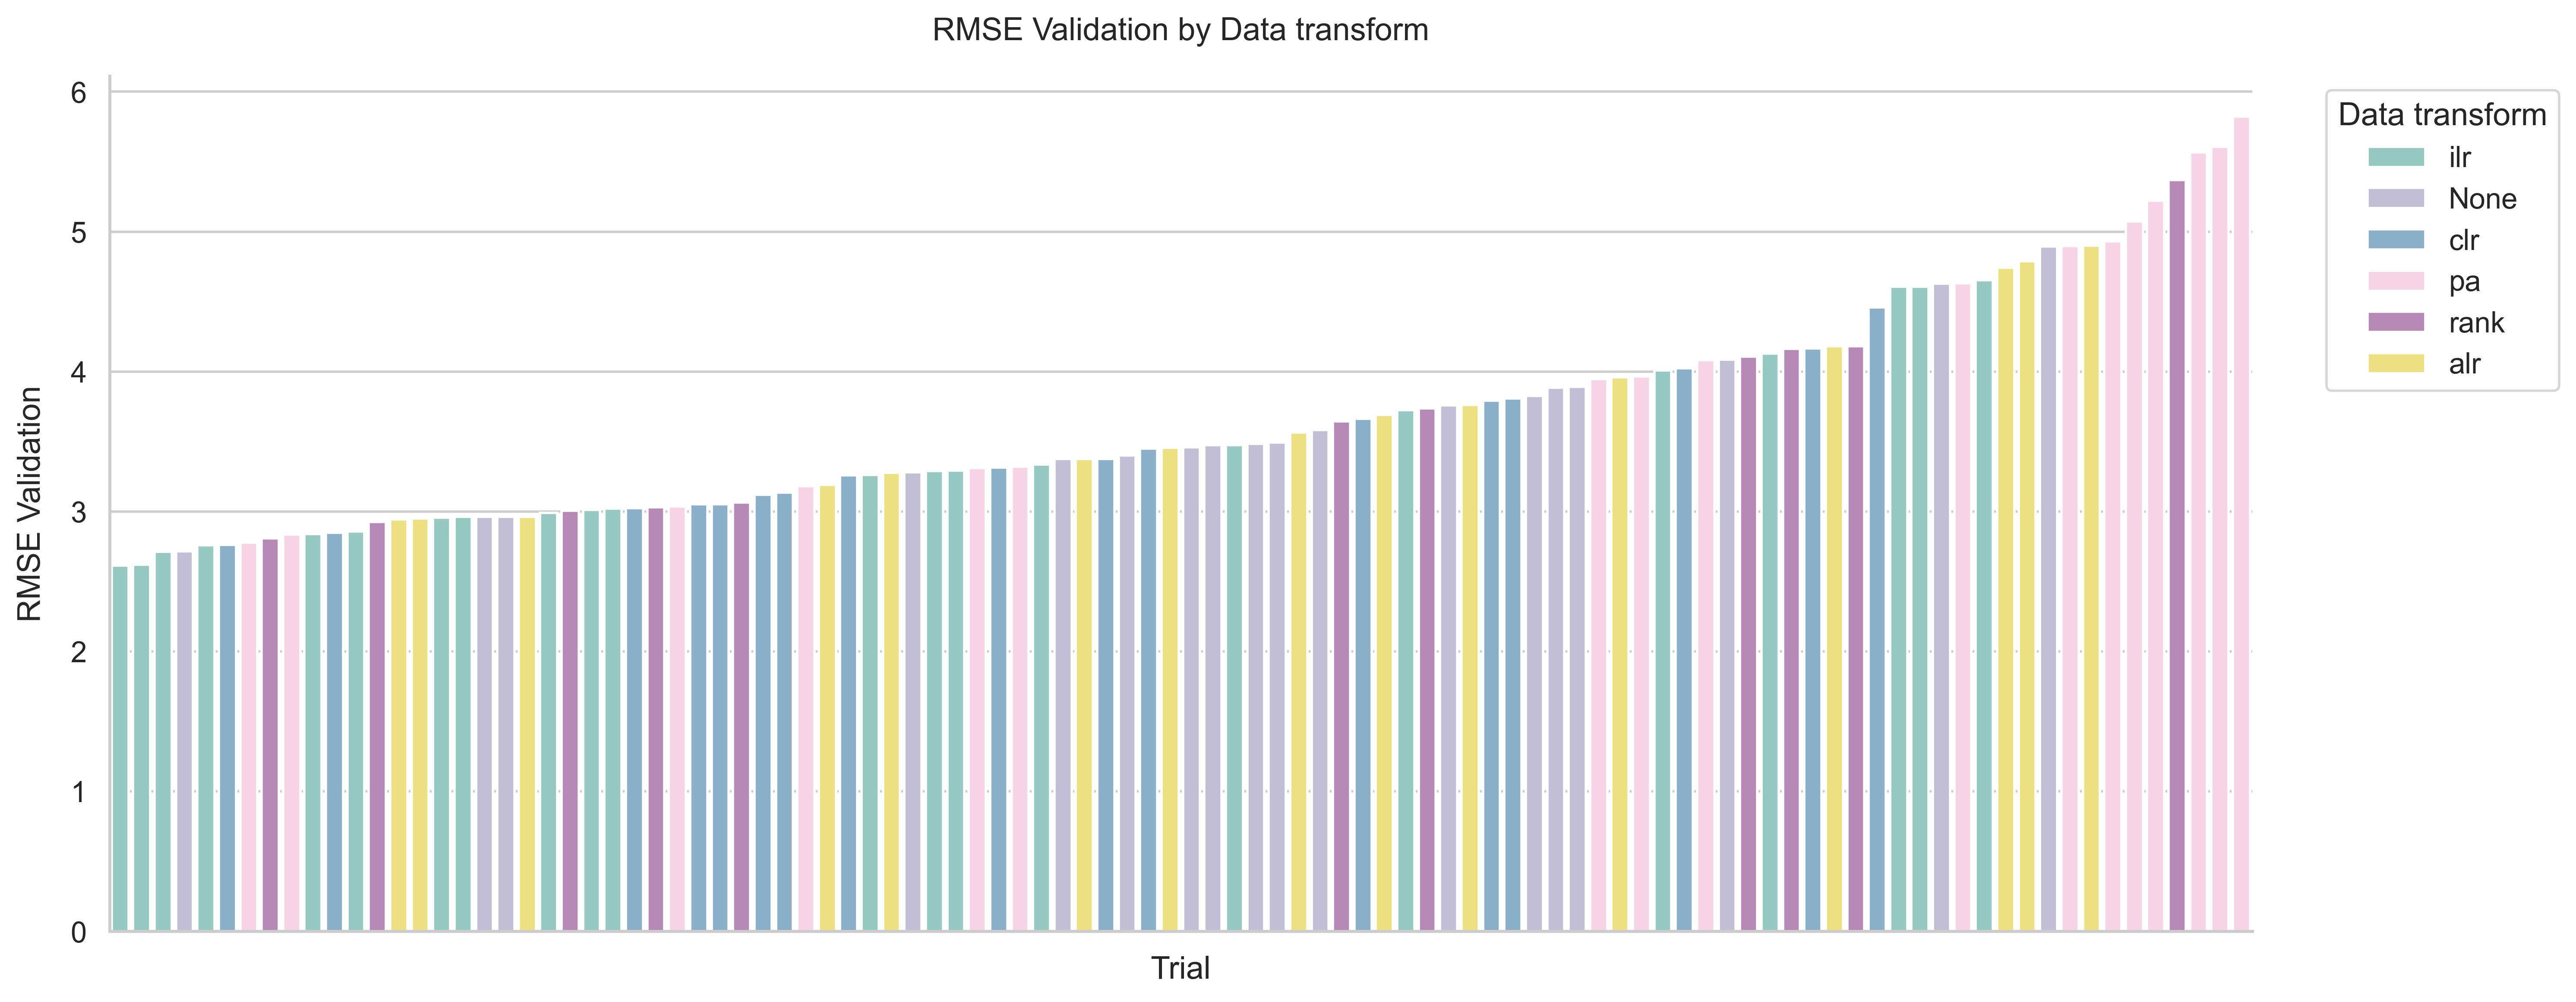

In [14]:
var = "params.data_transform"
var_name = "Data transform"

barplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
    display_trial_name=display_trial_id,
    top_n=top_n,
)

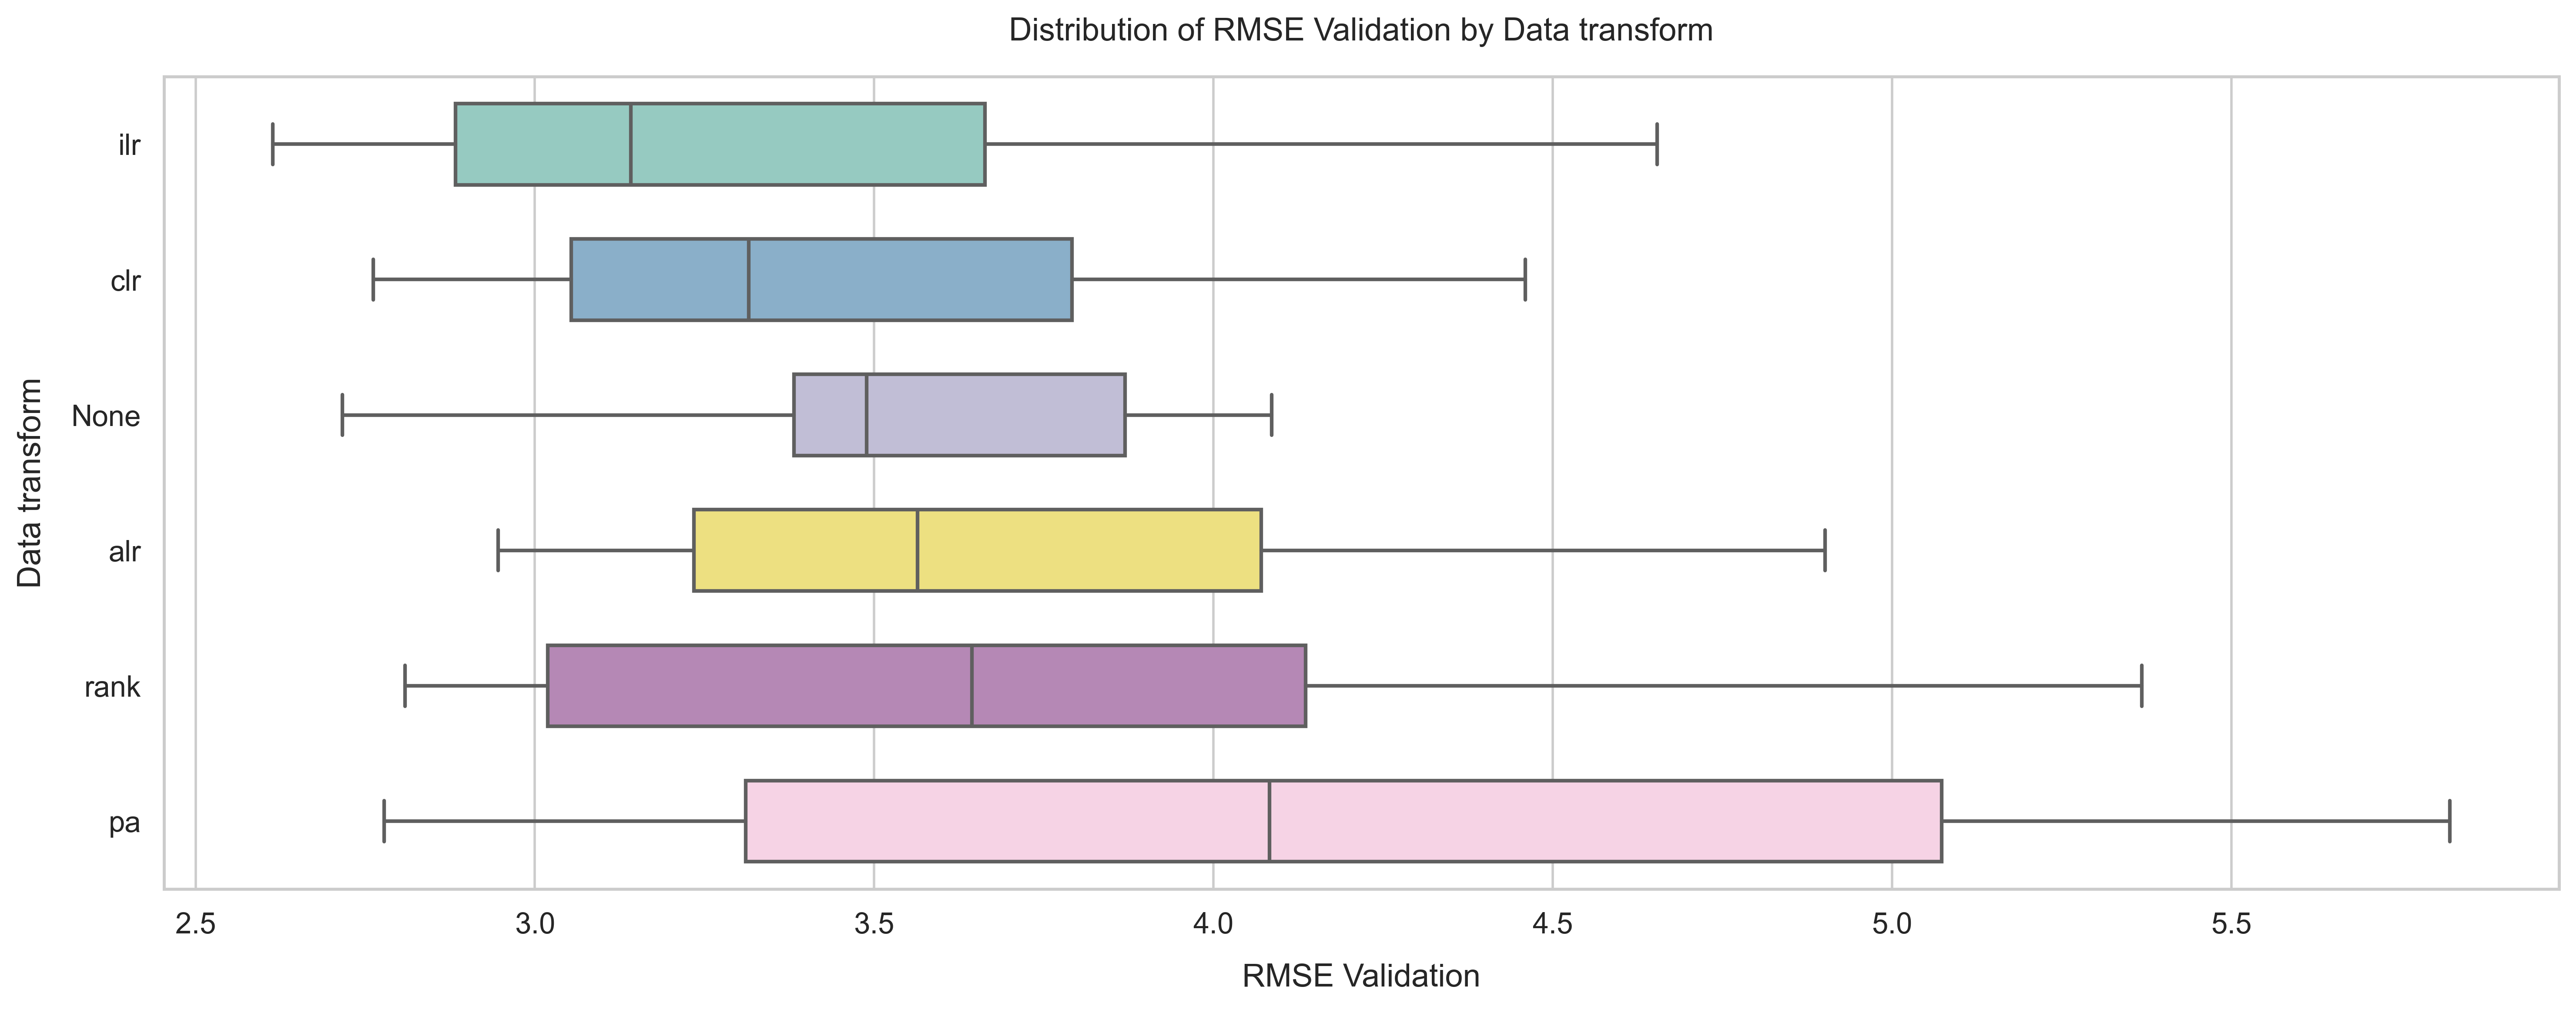

In [15]:
boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
)

In [9]:
parallel_coordinates_plot(all_trials, var, var_name, first_metric_cat=True)

### Effect of data selection

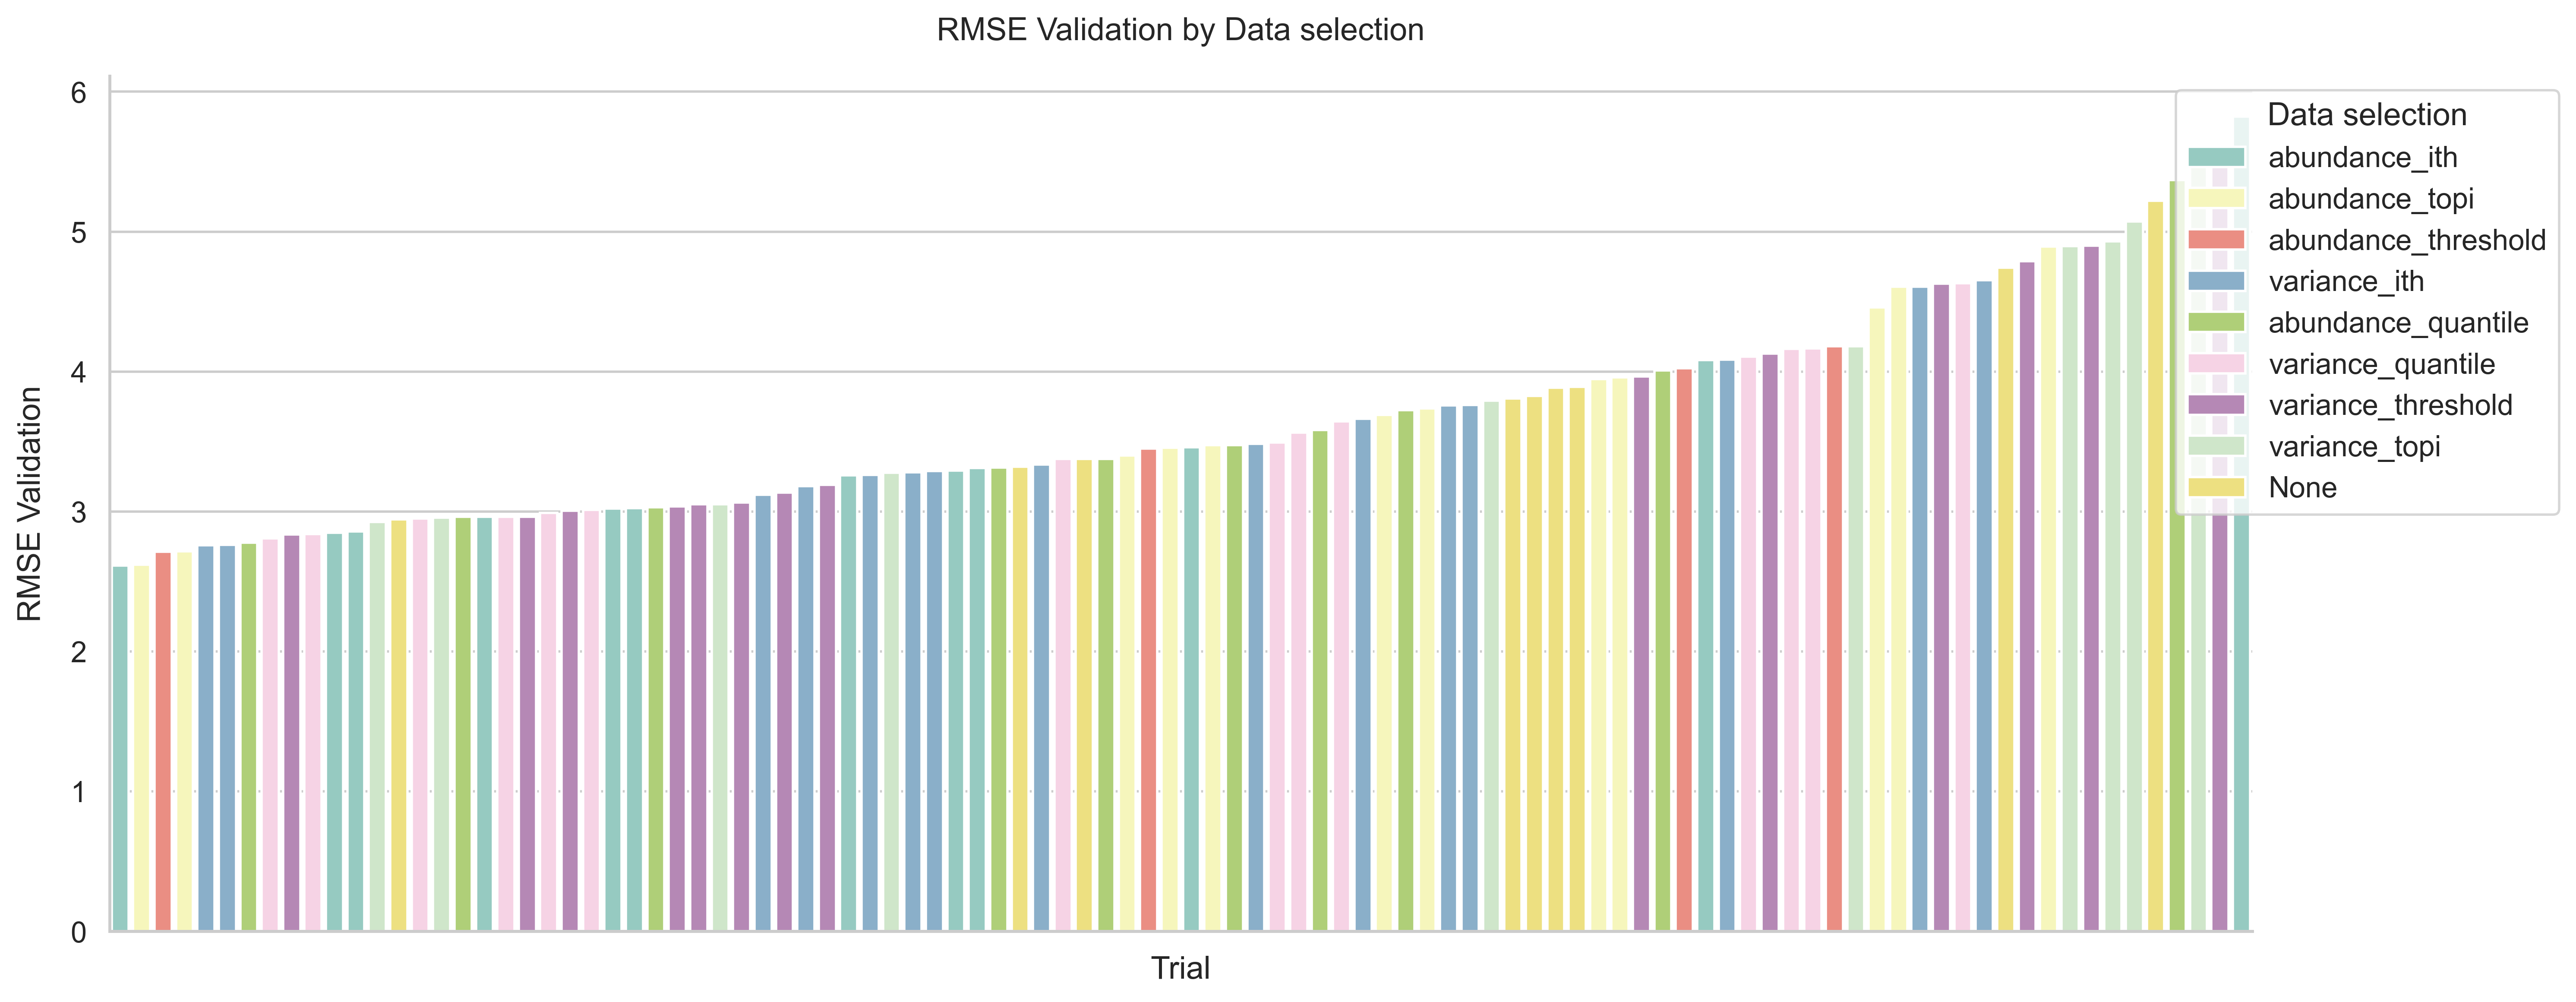

In [16]:
var = "params.data_selection"
var_name = "Data selection"

barplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
    display_trial_name=display_trial_id,
    top_n=top_n,
)

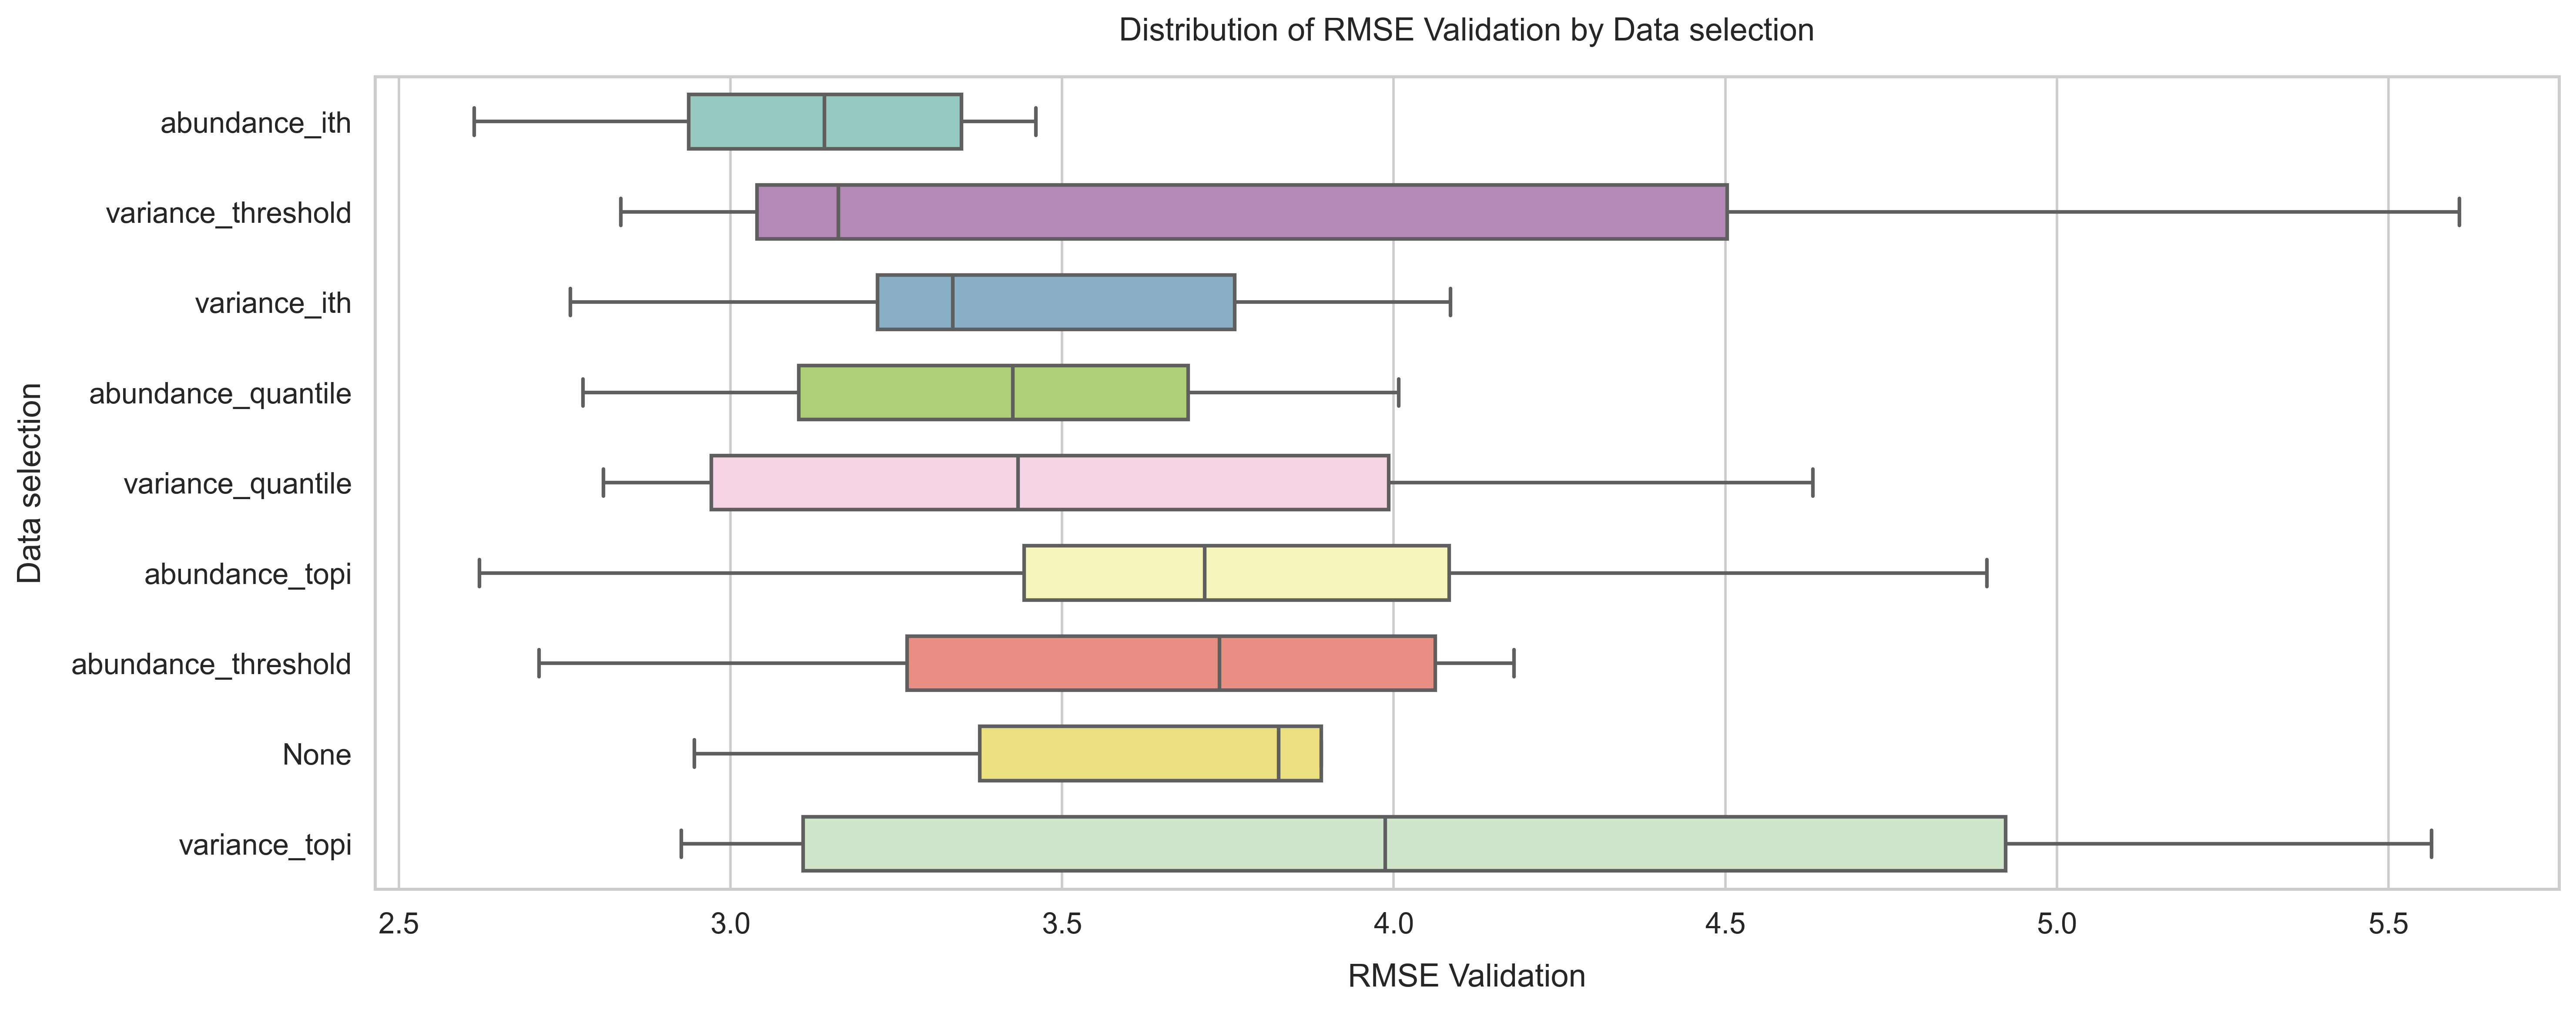

In [17]:
boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
)

In [ ]:
parallel_coordinates_plot(all_trials, var, var_name, first_metric_cat=True)

### Effect of data aggregation

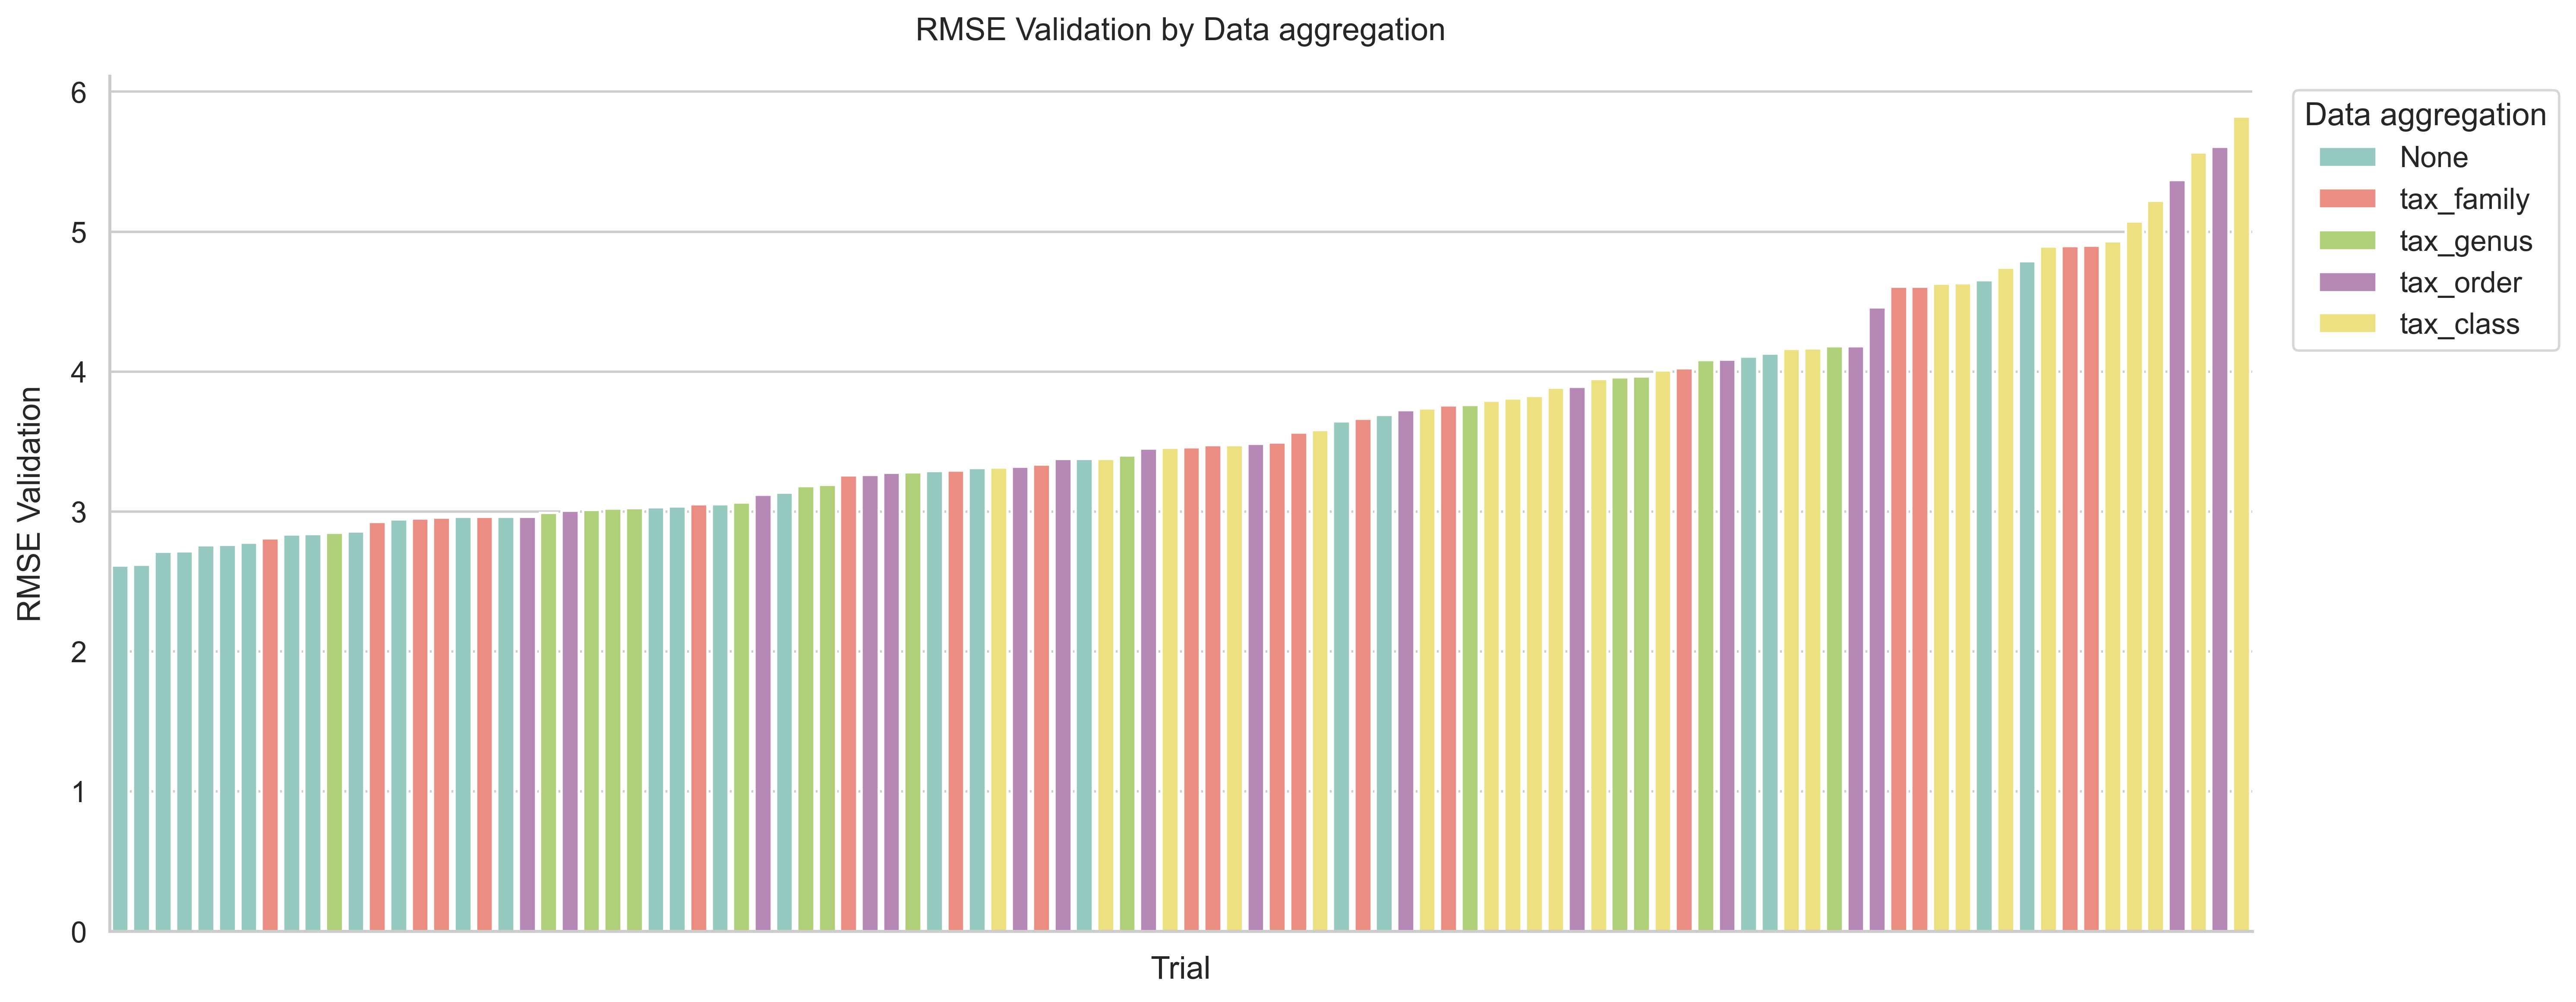

In [18]:
var = "params.data_aggregation"
var_name = "Data aggregation"

barplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
    display_trial_name=display_trial_id,
    top_n=top_n,
)

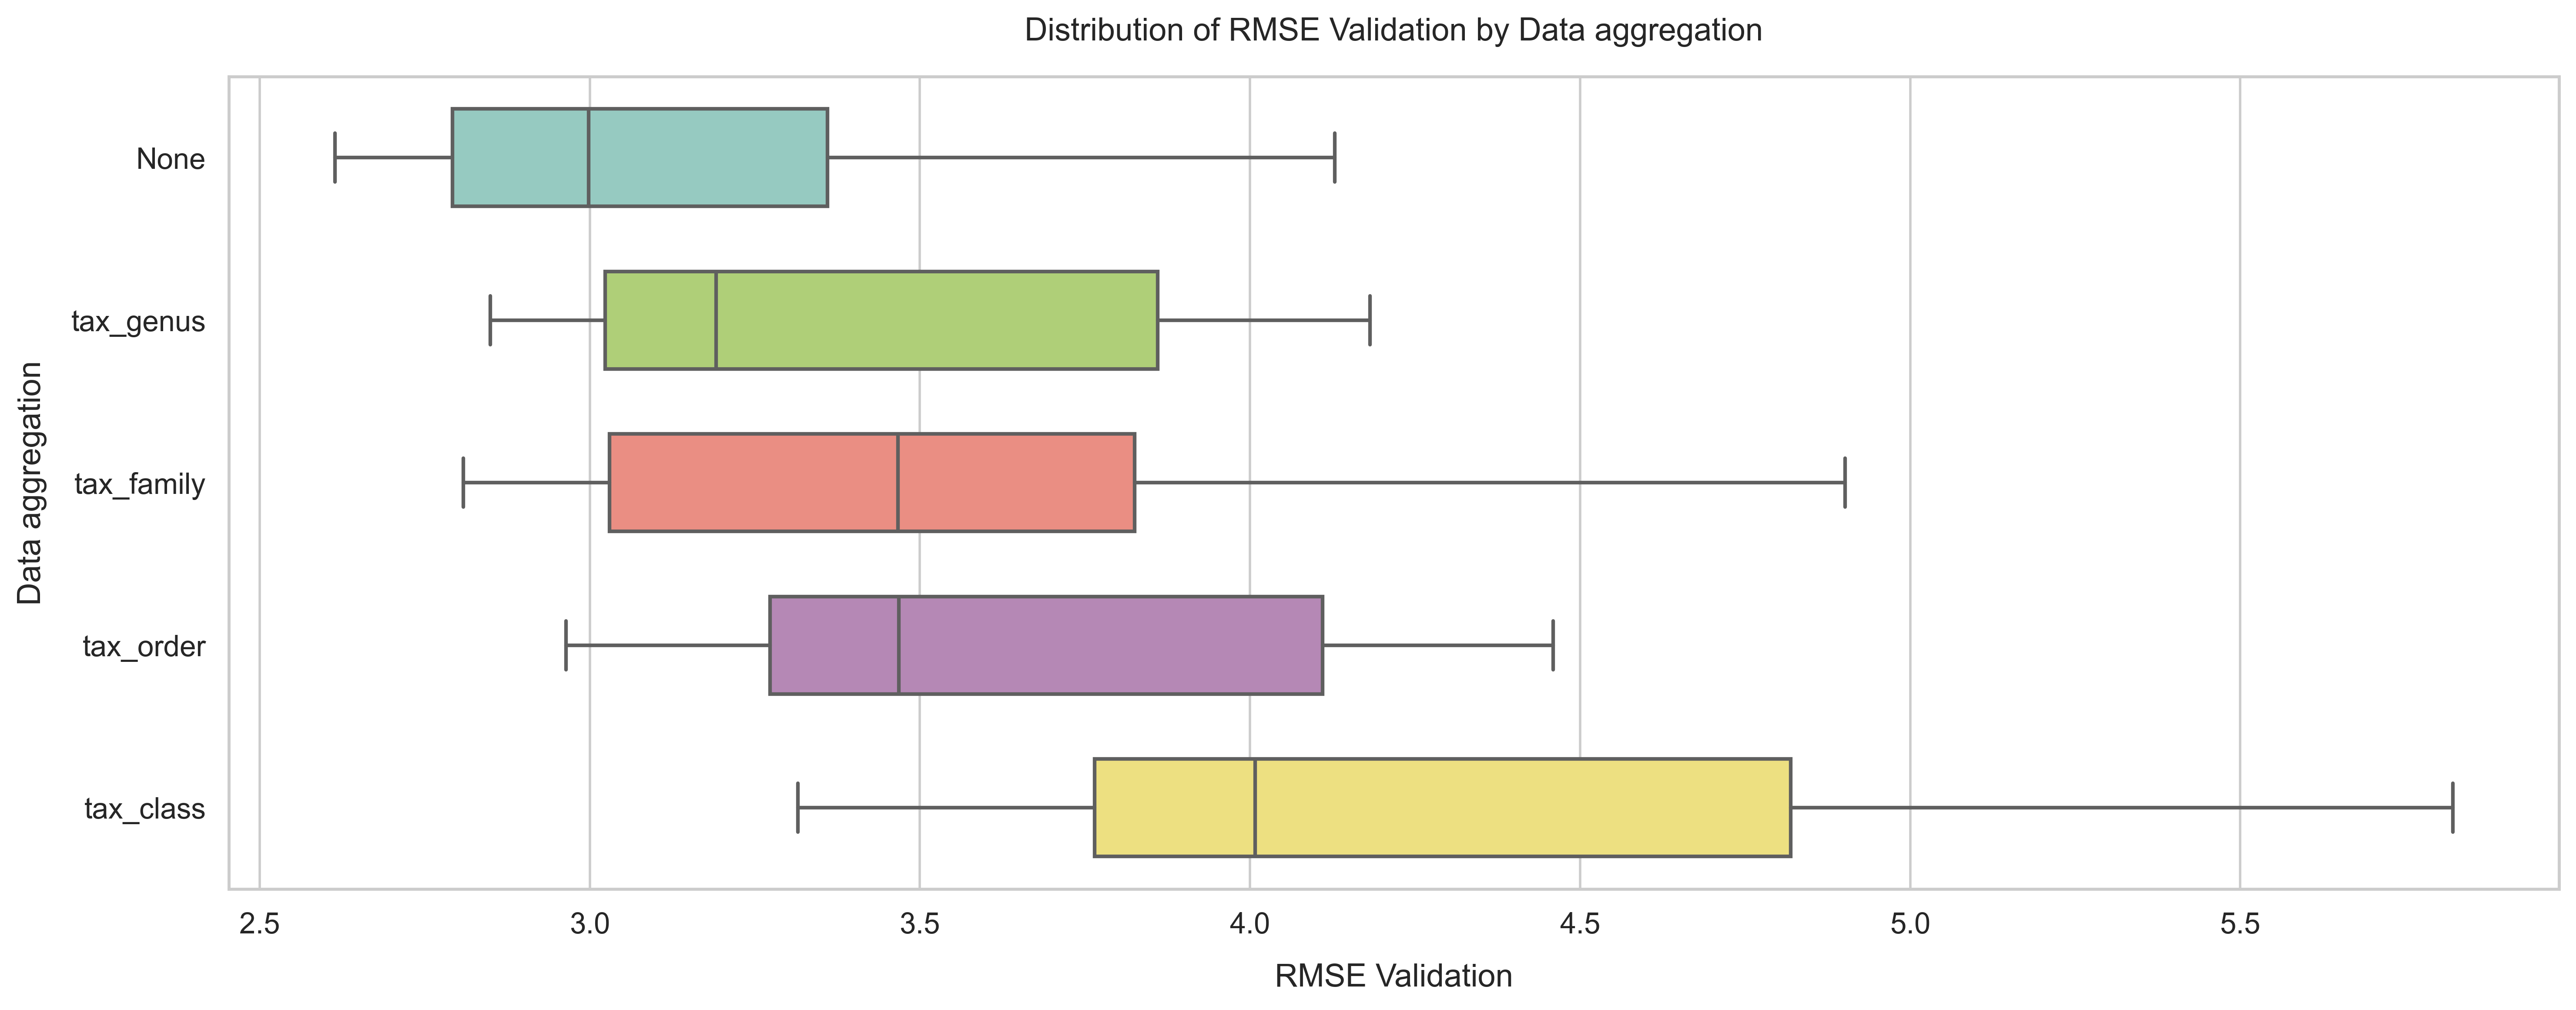

In [19]:
boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
)

In [ ]:
parallel_coordinates_plot(all_trials, var, var_name, first_metric_cat=True)

### Effect of data enrichment

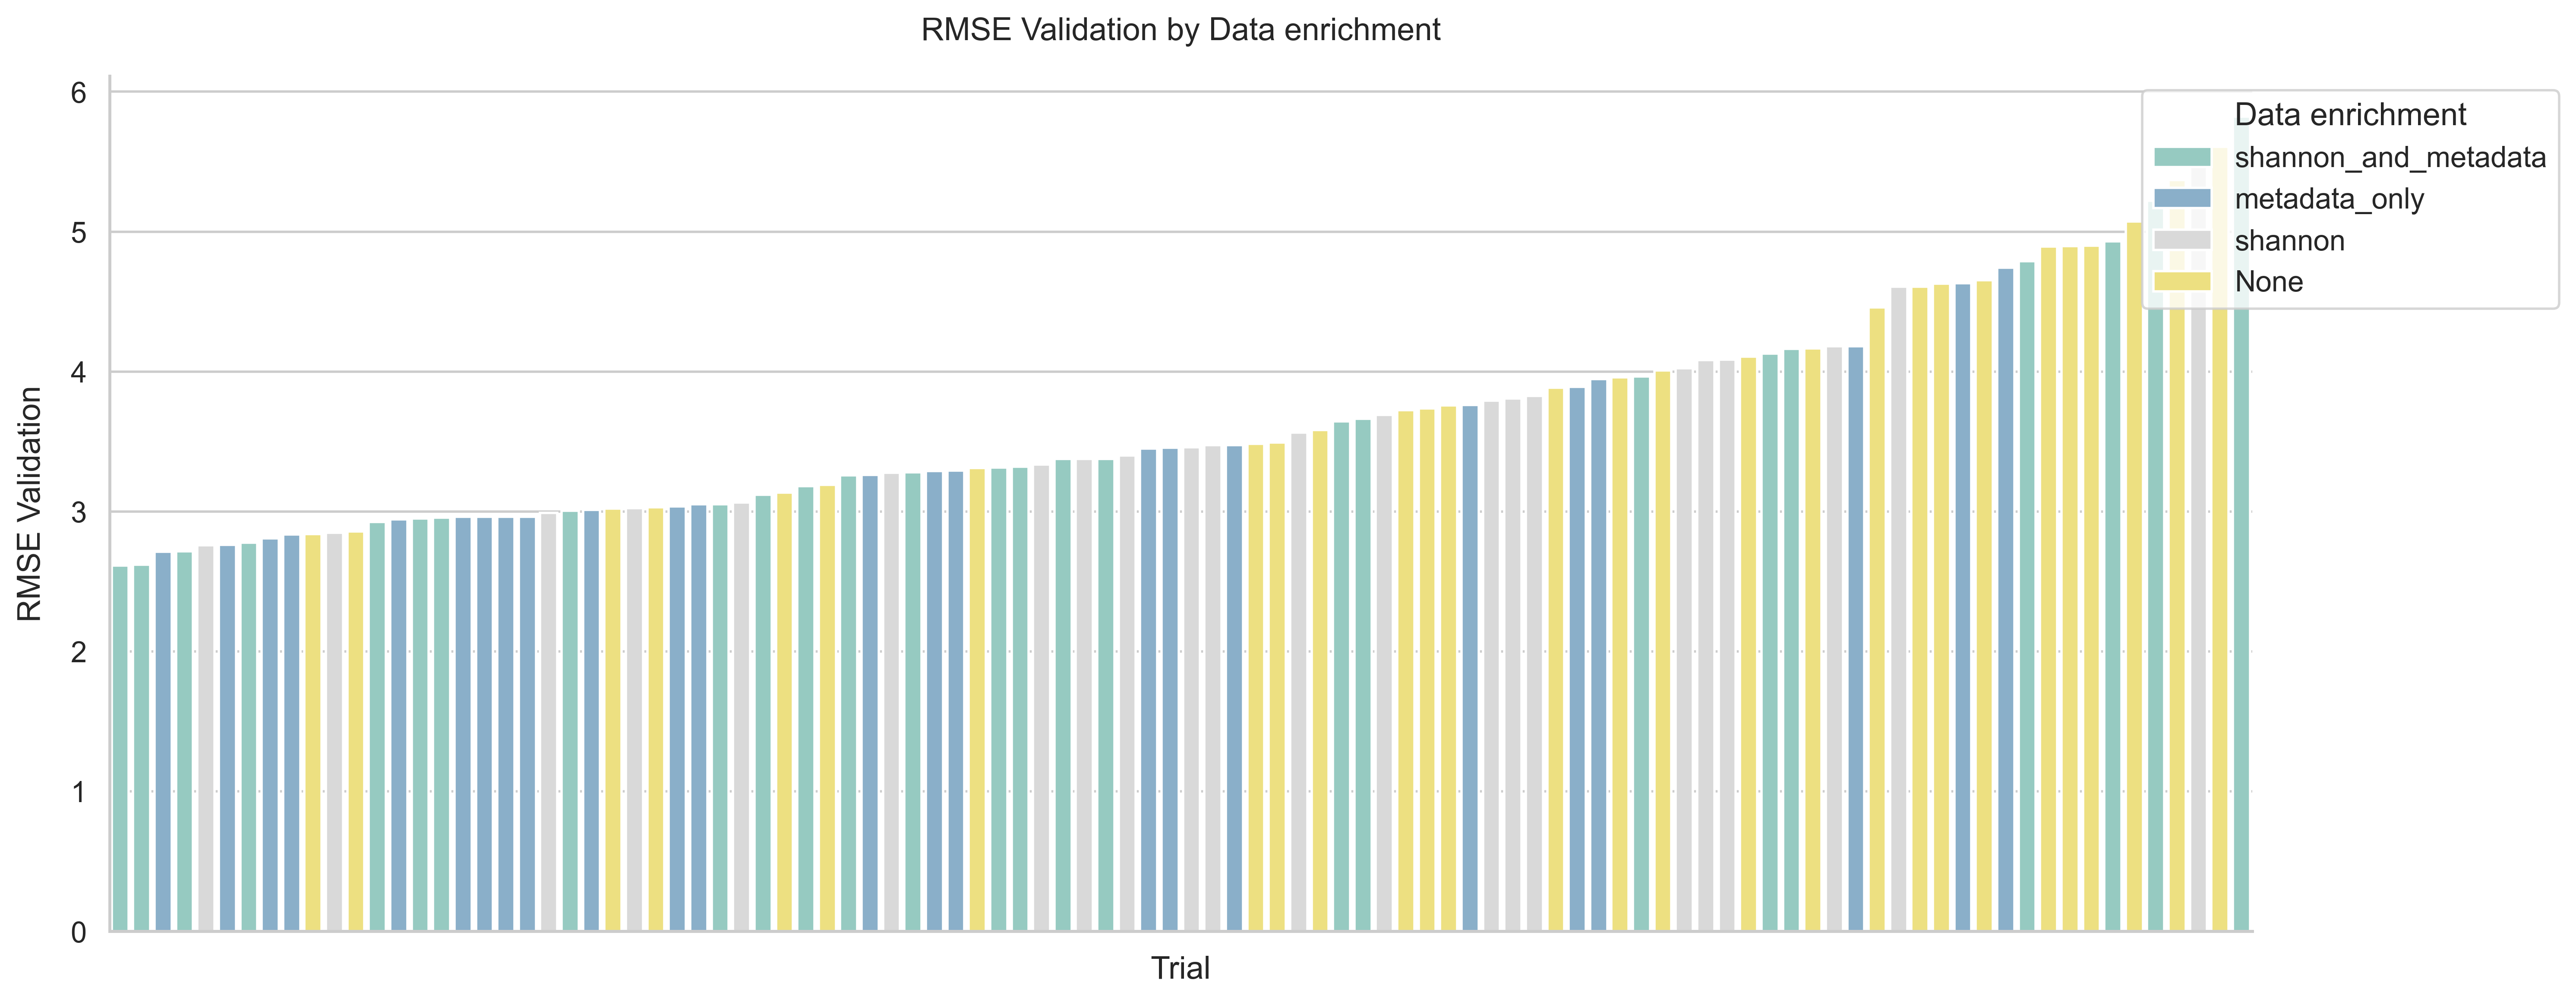

In [20]:
var = "params.data_enrich"
var_name = "Data enrichment"

barplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
    display_trial_name=display_trial_id,
    top_n=top_n,
)

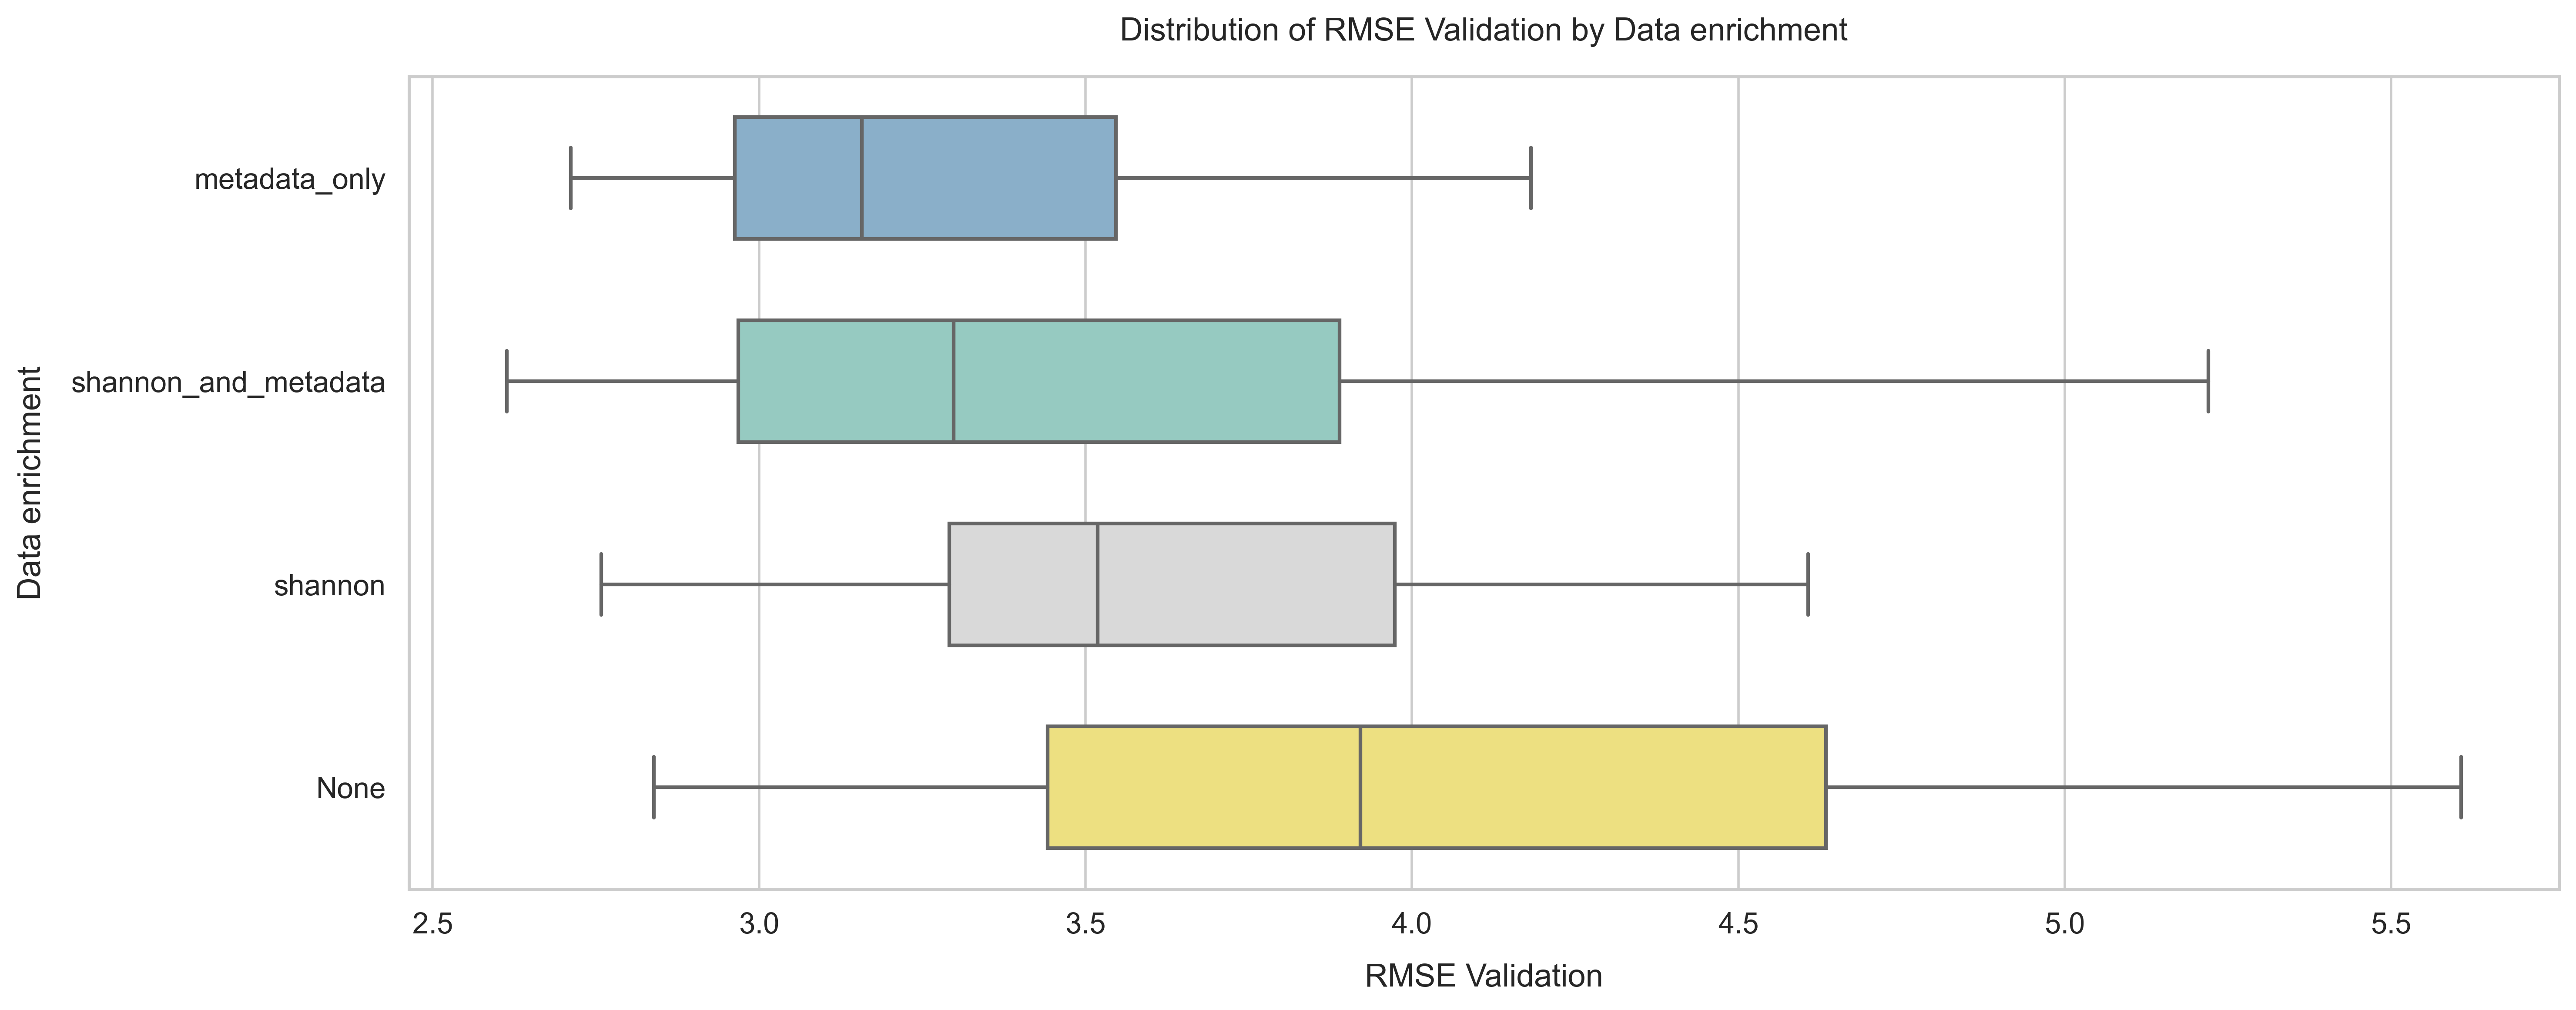

In [21]:
boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col=var,
    group_name=var_name,
)

In [ ]:
parallel_coordinates_plot(all_trials, var, var_name, first_metric_cat=True)

## Training over time

Plotting trend for model: rf


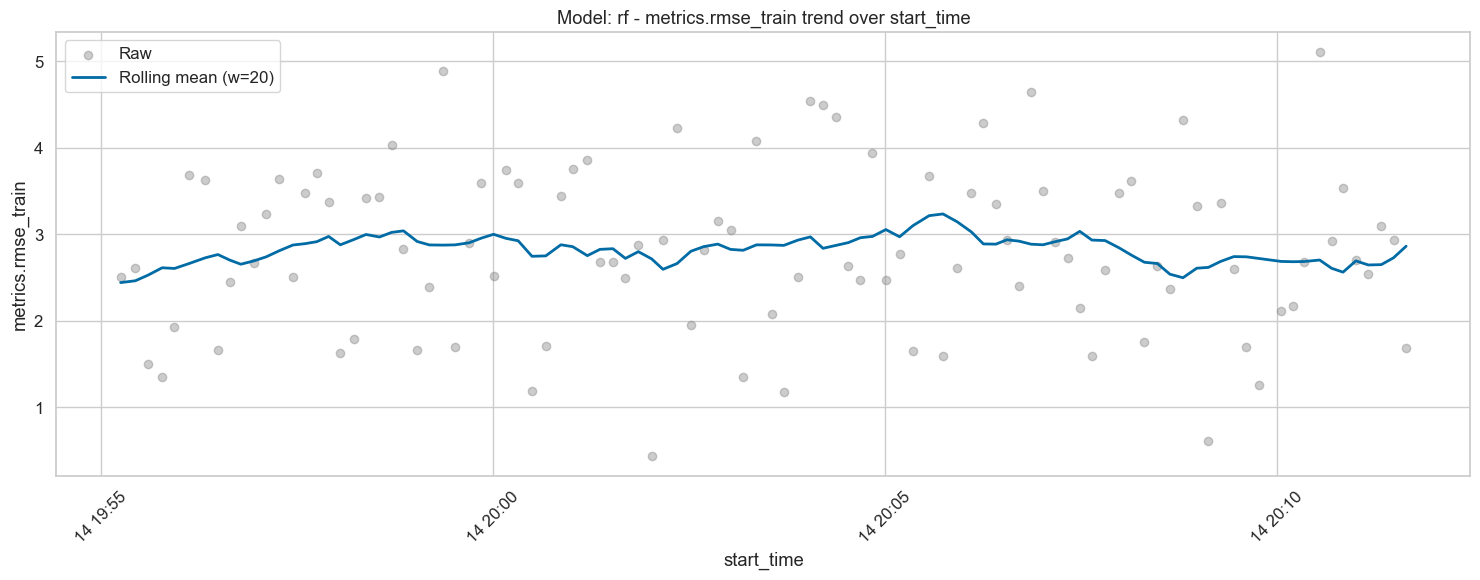

In [22]:
metric = "rmse_train"
for model in all_trials["params.model"].unique():
    print(f"Plotting trend for model: {model}")
    model_trials = all_trials[all_trials["params.model"] == model]
    plot_trend_over_time(
        model_trials, f"metrics.{metric}", window=20, title_prefix=f"Model: {model}"
    )

In [ ]:
client = mlflow.tracking.MlflowClient(tracking_uri=log_folder_location)

# one figure per model type
for model_type in all_trials["params.model"].unique():
    model_trials = all_trials[all_trials["params.model"] == model_type]
    plot_metric_history_per_model_type(metric, client, model_trials)

In [ ]:
# plot all metric history in one plot
plot_metric_history_per_model_type(metric, client, all_trials)

* If per model type later launched trials yield smaller RMSE train then the selected search algorithm works
* *Note:* The classification network (`nn_class`) is trained by minimizing the cross‐entropy loss, and the ordinal‐regression variant (`nn_corn`) is trained by minimizing the CORN loss.  herefore, training curves based on MSE‐derived metrics (e.g. RMSE) are not guaranteed to decrease monotonically during optimization for these models.

In [ ]:
plot_avg_history_per_model_type("rmse_train", client, all_trials)

In [ ]:
plot_avg_history_per_model_type("rmse_val", client, all_trials)

## Run configuration overview

In [ ]:
run_config = extract_run_config(all_trials)
run_config